In [713]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.base.model import GenericLikelihoodModel
import warnings
warnings.filterwarnings("ignore")
register_matplotlib_converters()

In [ ]:
#Read data
csv_file = 'CIC.csv'
df = pd.read_csv('DataSet\\'+csv_file)
df.dropna(inplace=True)
df

In [717]:
#data cleaning
df['Date'] = df['Year']
for index in df.index:
    if (df['Quarter'][index] == 'Q1'):
        df['Date'][index] = str(df['Year'][index]) + '-03-01'
    elif (df['Quarter'][index] == 'Q2'):
        df['Date'][index] = str(df['Year'][index]) + '-06-01'
    elif (df['Quarter'][index] == 'Q3'):
        df['Date'][index] = str(df['Year'][index]) + '-09-01'
    elif (df['Quarter'][index] == 'Q4'):
        df['Date'][index] = str(df['Year'][index]) + '-12-01'
#convert floating point to int then to str
# df['Date'] = df['Year'].astype(str) + '-' + (df['月'].astype(int)).astype(str) + '-01'
# df.head()

In [752]:
#Data cleaning
df_clean = df.loc[:,['Date','Total']]
df_clean.rename(columns={'Date':'date','Total':'total'},inplace=True)
df_clean['date'] = pd.to_datetime(df_clean.date)
df.dropna(inplace=True)
df_clean.tail()

,date,total
210,2021-06-01,592566
211,2021-09-01,592153
212,2021-12-01,606030
213,2022-03-01,621073
214,2022-06-01,626793


In [753]:
#Subseting data, Leave some data for forcecasting
df_clean.set_index('date',inplace=True)
start_date = pd.to_datetime('1968-01-01')
end_date = pd.to_datetime('2021-01-01')
df_clean = df_clean[start_date:end_date]
df.dropna(inplace=True)
df_clean.tail()
df_train = df_clean.copy()

In [743]:
#Useful functions
#Print Graph
def plotGraph(dataframe, column, plottitle, plotylabel, startyear, endyear):
    plt.figure(figsize=(10,4))
    plt.plot(dataframe[column])
    plt.title(plottitle, fontsize=20)
    plt.ylabel(plotylabel, fontsize=16) 
    for year in range(startyear,endyear):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

#Augmented Dickey-Fuller (ADF) Test:
#Null hypothesis: non-stationary - if p-value < 5% reject null hypothesis
def ADFtest(dataframe, column):
    adfuller_result = adfuller(dataframe[column].values, autolag='AIC')
    print(f'ADF statistic: {adfuller_result[0]}')
    print(f'p-value      : {adfuller_result[1]}')
    for key, value in adfuller_result[4].items():
        print('Critical values:')
        print(f'  {key},  {value}')
    if (adfuller_result[1] < 0.05):
        print('It is stationary')
    else:
        print('It is non-stationary')

#The additive model is useful when the seasonal variation is relatively constant over time.
#The multiplicative model is useful when the seasonal variation increases over time.
def seasonDecomposer(dataframe, column, models='additive', periods=1):
    plt.rcParams.update({'figure.figsize':(10,10)})
    seasonal_decompose(dataframe[column], model=models, period=periods).plot().suptitle(f'\n{models} decompose', fontsize=12)

#Combine all funtions
def plotAll(dataframe, column, plottitle, plotylabel, startyear, endyear, models='additive', periods=1):
    ADFtest(dataframe, column)
    plotGraph(dataframe, column, plottitle, plotylabel, startyear, endyear)
    # “ywm” : Yule-Walker without adjustment. Default.
    # “yw”  : Yule-Walker with sample-size adjustment in denominator for acovf. Default.
    #alpha  : 0.05 = 95% confidence interval
    plot_acf(dataframe[column],  alpha=.05, lags=30)
    plot_pacf(dataframe[column],  alpha=.05, method='ywm',lags=30)   
    seasonDecomposer(dataframe, column, models, periods)

def allStationarity(dataframe,column):
    dataframe['after_log'] = np.log(dataframe[column])
    dataframe['difference_1'] = dataframe[column] - dataframe[column].shift(1)
    dataframe['difference_2'] = dataframe[column] - 2*dataframe[column].shift(1) + dataframe[column].shift(2)
    dataframe['log_difference_1'] = dataframe['after_log'] - dataframe['after_log'].shift(1)
    dataframe['log_difference_2'] = dataframe['after_log'] - 2*dataframe['after_log'].shift(1) + dataframe['after_log'].shift(2)
    dataframe.dropna(inplace=True)
    for data in [column,'after_log','difference_1','difference_2','log_difference_1','log_difference_2']:
        adfuller_result = adfuller(dataframe[data].values, autolag='AIC')
        if (adfuller_result[1] < 0.05):
            print(data + ' : stationary')
        else:
            print(data + ' : non-stationary')

def lgBoxResult(result):
    test_stat = result[0][0]
    p_value = result[0][1]
    for i in range(len(test_stat)):
        print(f'At Lag: {i}, Test statistic: {test_stat[i]}, p-value:{p_value[i]}')
        if (p_value[i] < 0.05):
            print(f'p-value < 0.05, Null hypothesis is rejected, there is serial correlation.')
        else:
            print(f'p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.')
        print('------------------------------------------------------------------------------------------')
    

ADF statistic: 4.181957817934027
p-value      : 1.0
Critical values:
  1%,  -3.464161278384219
Critical values:
  5%,  -2.876401960790147
Critical values:
  10%,  -2.5746921001665974
It is non-stationary


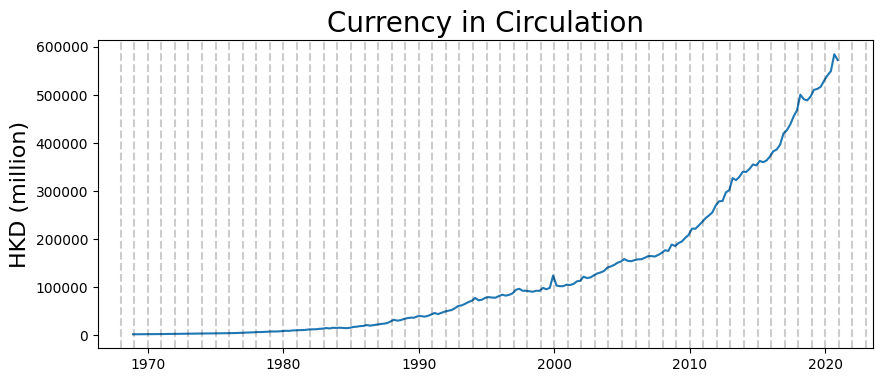

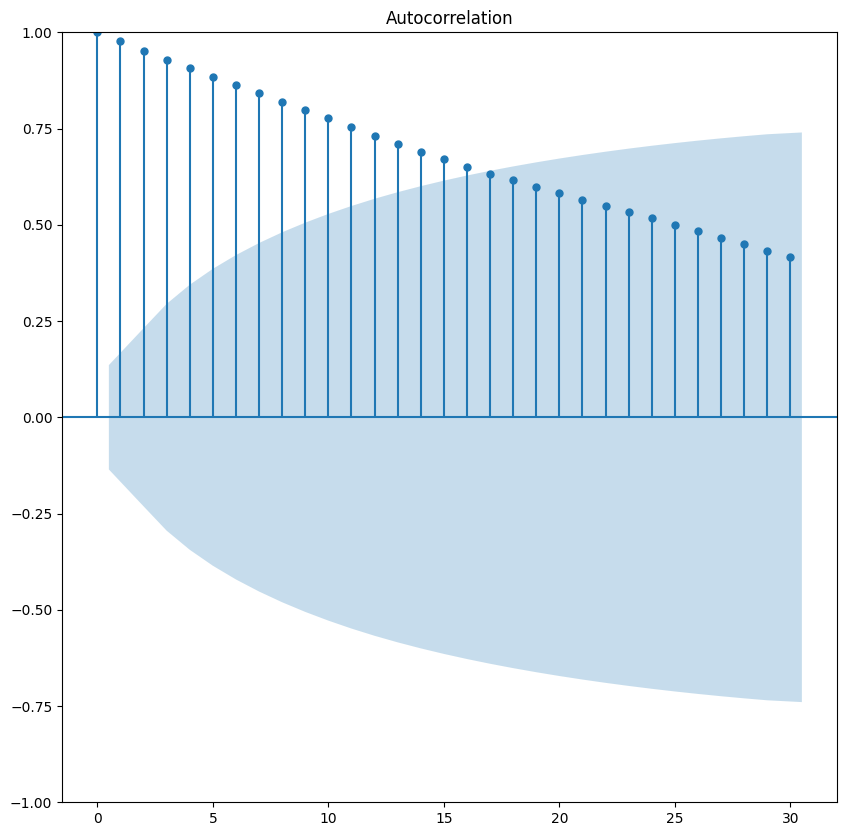

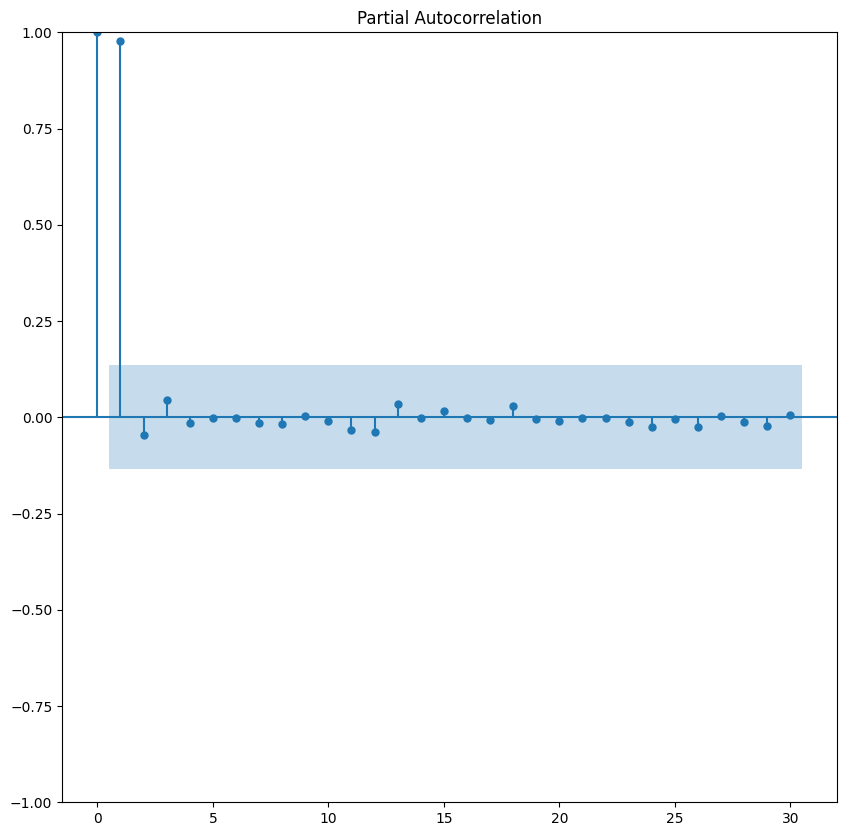

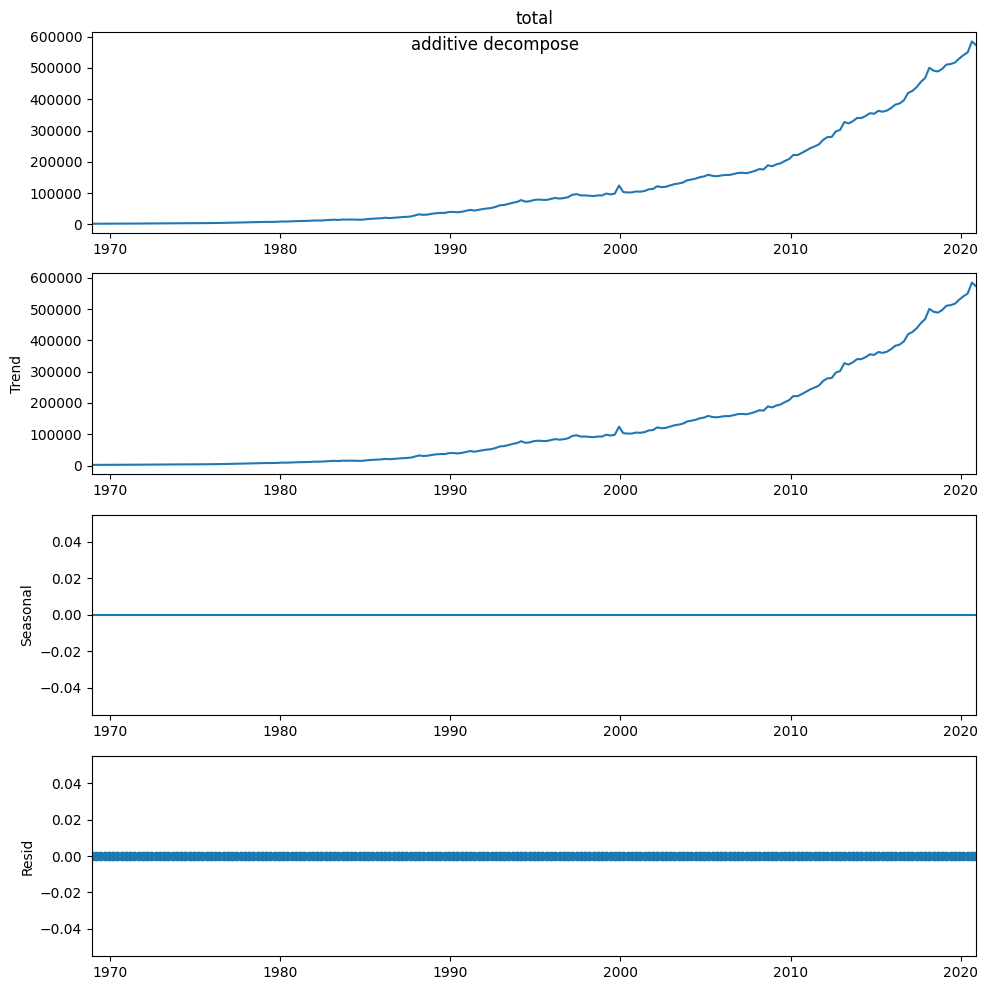

In [754]:
plotAll(df_clean, 'total', 'Currency in Circulation', 'HKD (million)', 1968, 2024, models='additive', periods=1)

In [755]:
#All stationarity result after log and differencing
# ['after_log','difference_1','difference_2','log_difference_1','log_difference_2']
allStationarity(df_clean,'total')

total : non-stationary
after_log : non-stationary
difference_1 : non-stationary
difference_2 : stationary
log_difference_1 : non-stationary
log_difference_2 : stationary


In [ ]:
#Log Transformation
# plotAll(dataframe, column, plottitle, plotylabel, startyear, endyear, models='additive', periods=1)
plotAll(df_clean, 'after_log', 'CPI Over Time (log)', 'CPI', 2000, 2024, models='additive', periods=1)

In [ ]:
#First order differencing
plotAll(df_clean, 'difference_1', 'CPI Over Time (log, d=1)', 'CPI', 2000, 2024, models='additive', periods=1)

ADF statistic: -7.69996805099968
p-value      : 1.3474736541502755e-11
Critical values:
  1%,  -3.464161278384219
Critical values:
  5%,  -2.876401960790147
Critical values:
  10%,  -2.5746921001665974
It is stationary


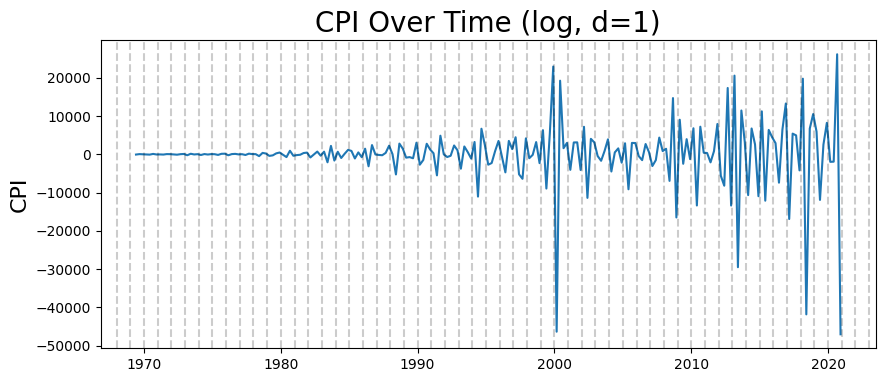

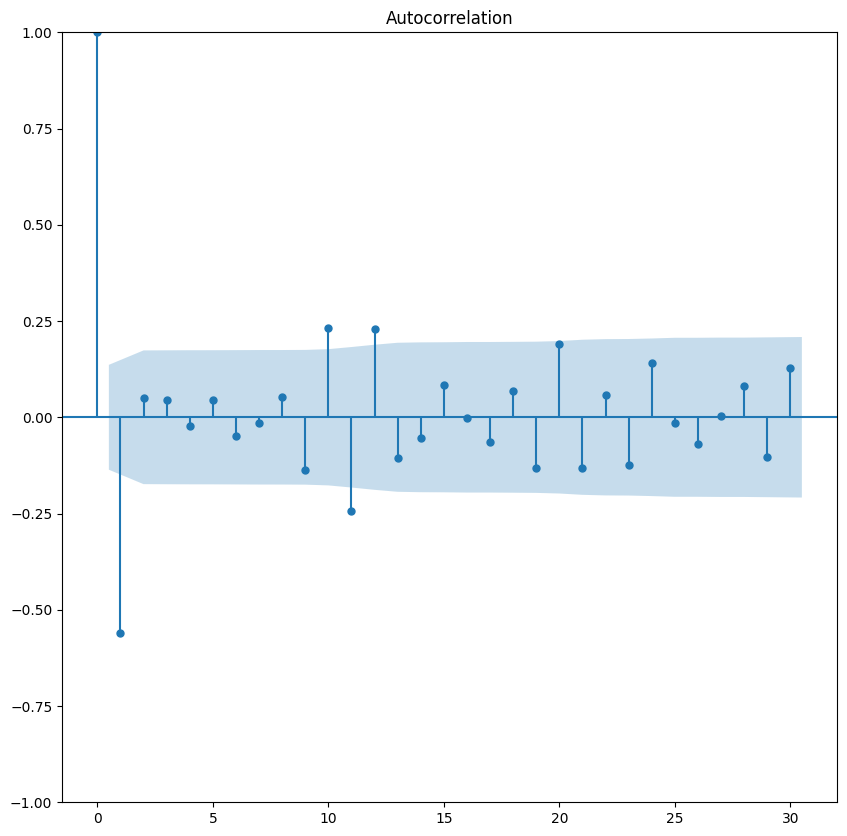

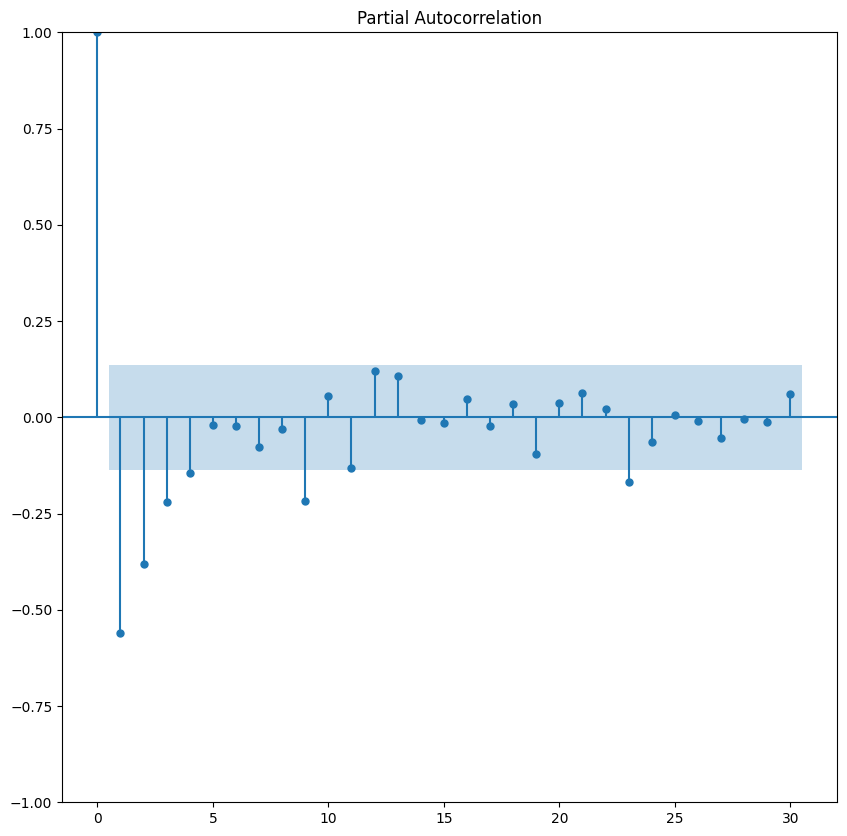

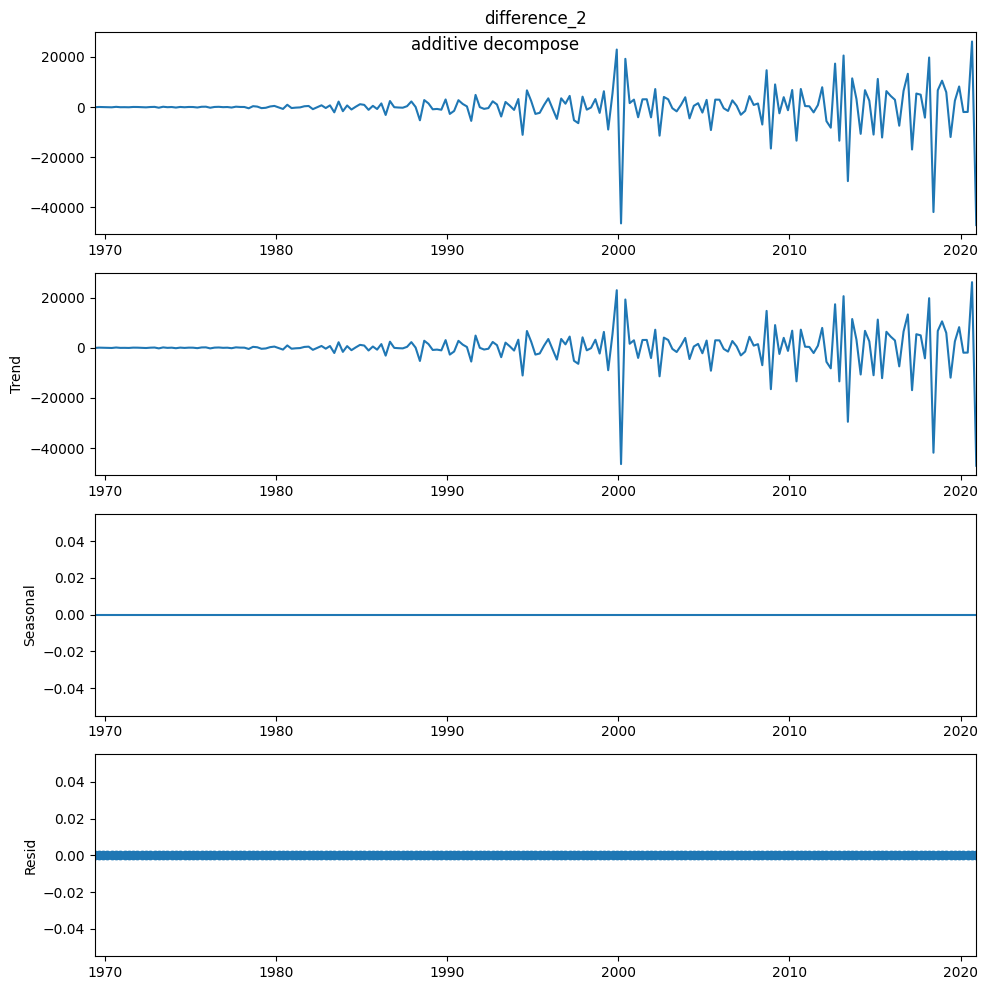

In [756]:
#Second order differencing
plotAll(df_clean, 'difference_2', 'CPI Over Time (log, d=1)', 'CPI', 1968, 2024, models='additive', periods=1)

In [757]:
model = ARIMA(df_train, order=(1,2,0))
#Using Maximum likelihood estimation
model_fit = model.fit(method='innovations_mle')
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:                  209
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -2111.424
Date:                Mon, 14 Nov 2022   AIC                           4226.849
Time:                        03:14:50   BIC                           4233.514
Sample:                    12-01-1968   HQIC                          4229.544
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6604      0.025    -26.705      0.000      -0.709      -0.612
sigma2      4.238e+07    1.3e-10   3.27e+17      0.000    4.24e+07    4.24e+07
Ljung-Box (L1) (Q):                  16.38   Jarque-

In [764]:
'''
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.test_serial_correlation.html
Ljung-Box test for no serial correlation of standardized residuals
Null hypothesis is no serial correlation.
df_adjust: when true df = k-p-q
lags: default maxlag is min(10, number of observation//5)
'''
result = model_fit.test_serial_correlation(method='ljungbox',df_adjust=True, lags=6)
lgBoxResult(result)

At Lag: 0, Test statistic: 16.3788207812011, p-value:nan
p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.
------------------------------------------------------------------------------------------
At Lag: 1, Test statistic: 40.356490371762504, p-value:2.1160131879064014e-10
p-value < 0.05, Null hypothesis is rejected, there is serial correlation.
------------------------------------------------------------------------------------------
At Lag: 2, Test statistic: 43.27800363099115, p-value:4.0022196289162984e-10
p-value < 0.05, Null hypothesis is rejected, there is serial correlation.
------------------------------------------------------------------------------------------
At Lag: 3, Test statistic: 43.85024219673975, p-value:1.623874598091874e-09
p-value < 0.05, Null hypothesis is rejected, there is serial correlation.
------------------------------------------------------------------------------------------
At Lag: 4, Test statistic: 44.66844349949307,